<a href="https://colab.research.google.com/github/ocoropuj/Econ-424/blob/main/Econ_424_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.optimize import minimize
from numpy.linalg import inv


# Disclaimer: This code uses python, and gets the data directly from Yahoo Finance. The monthly data is taken as the last avaiable data point from each month. It is possible that if the custom R library, the monthly data is achieveed diferently, some numbers might be slightly off.

# Part I: GWN Model Estimation

Consider the GWN Model for cc returns, which we will use as an approximation for simple returns:

\begin{align}
R_{it} & = \mu_i + \epsilon_{it}, t=1,\cdots,T \\
\epsilon_{it} & \sim \text{iid } N(0, \sigma_{i}^{2}) \\
\mathrm{cov}(R_{it}, R_{jt}) & = \sigma_{i,j} \\
\mathrm{cov}(R_{it}, R_{js}) & = 0 \text{ for } s \ne t
\end{align}

where $R_{it}$ denotes the simple return on asset $i$ ($i=\mathrm{AMZN}, \cdots, \mathrm{SBUX}$).

1. Using sample descriptive statistics, give estimates for the model parameters $\mu_i, \sigma_{i}^{2}, \sigma_i, \sigma_{i,j}, \rho_{i,j}$. Put the estimated mean values in the vector `muhat.vals` and put the estimated covariance matrix in the matrix object `sigma.mat.` These will be inputs for the portfolio theory examples.



In [ ]:
Fivestocks = pd.read_csv('Fivestocks.csv')
fs = Fivestocks.copy()
fs.index = pd.to_datetime(fs['Date'])
fs = fs.drop('Date', axis=1)
FS_Month = fs.resample('M').last()
fs_ret = np.log(fs).diff().dropna()
FS_Month_ret = (FS_Month).pct_change().dropna()

In [ ]:
FS_Month_2017_2021 = FS_Month.loc['2017-01-31':'2021-12-31']
FS_Month_ret_2017_2021 = FS_Month_ret.loc['2017-01-31':'2021-12-31']
FS_Month = FS_Month_2017_2021
FS_Month_ret = FS_Month_ret_2017_2021

In [ ]:
mu = FS_Month_ret.mean()
sig2 = FS_Month_ret.var()
sig = FS_Month_ret.std()

cov = FS_Month_ret.cov()
cor = FS_Month_ret.corr()

print(f'Mean: {mu} \n')
print(f'Variance: {sig2} \n')
print(f'Standard Deviation: {sig} \n')
print(f'Covariance: {cov} \n')
print(f'Correlation: {cor} \n')

Mean: AMZN    0.028244
BA      0.013473
COST    0.024642
JWN     0.006274
SBUX    0.016296
dtype: float64 

Variance: AMZN    0.006445
BA      0.015489
COST    0.002838
JWN     0.039581
SBUX    0.004417
dtype: float64 

Standard Deviation: AMZN    0.080280
BA      0.124454
COST    0.053269
JWN     0.198950
SBUX    0.066460
dtype: float64 

Covariance:           AMZN        BA      COST       JWN      SBUX
AMZN  0.006445  0.001393  0.001789  0.001724  0.001162
BA    0.001393  0.015489  0.000957  0.014640  0.002308
COST  0.001789  0.000957  0.002838  0.001641  0.001357
JWN   0.001724  0.014640  0.001641  0.039581  0.003958
SBUX  0.001162  0.002308  0.001357  0.003958  0.004417 

Correlation:           AMZN        BA      COST       JWN      SBUX
AMZN  1.000000  0.139388  0.418446  0.107941  0.217860
BA    0.139388  1.000000  0.144331  0.591282  0.278994
COST  0.418446  0.144331  1.000000  0.154829  0.383391
JWN   0.107941  0.591282  0.154829  1.000000  0.299310
SBUX  0.217860  0.278994  

2. Show the estimated risk-return tradeoff of these assets (i.e., plot the means on the y-axis and the standard deviations on the horizontal axis. Briefly comment.
    + Assuming a risk free rate of 0.005 (0.5% per month or about 6% per year) compute the Sharpe ratios for each asset. Which asset has the highest Sharpe ratio?



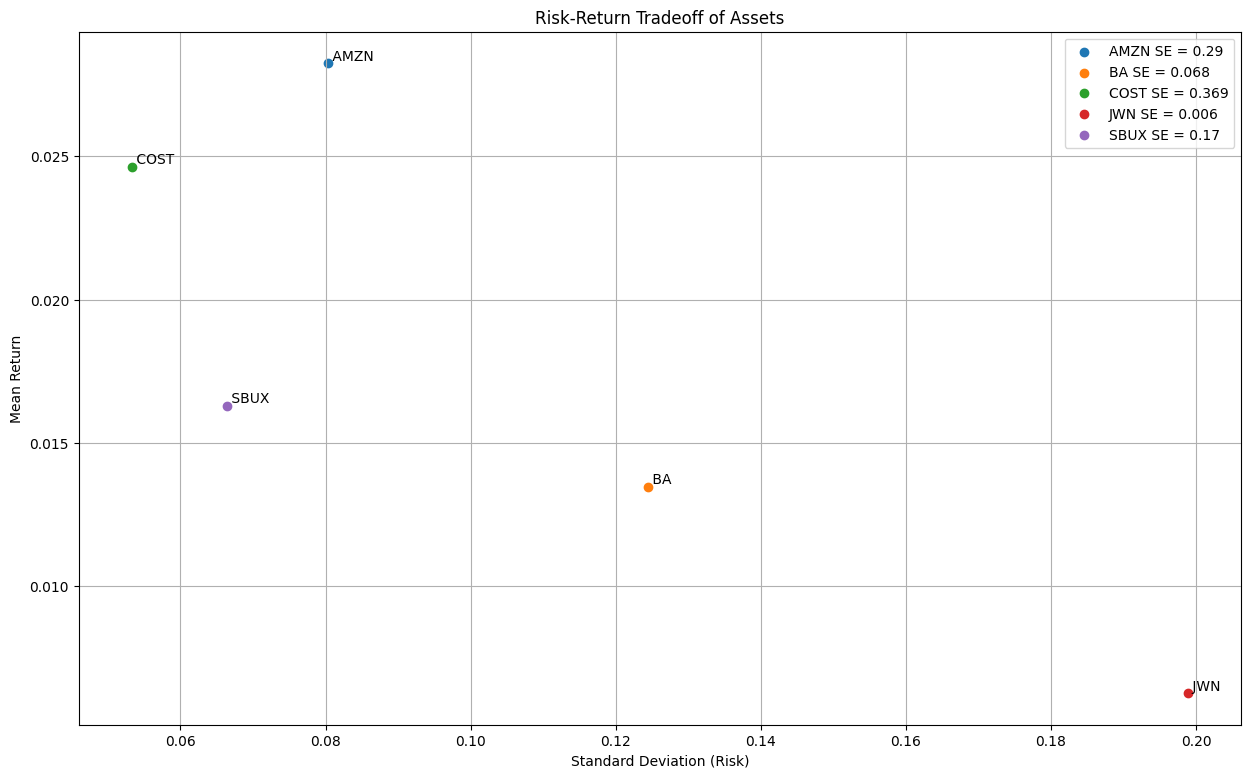

In [ ]:
# Compute Sharpe Ratios
risk_free_rate = 0.005
# Plot the mean vs. standard deviation for each asset
plt.figure(figsize=(15, 9))
for stock in mu.index:
    sharpe_ratio = (mu[stock] - risk_free_rate) / sig[stock]

    plt.scatter(sig[stock], mu[stock], label=f'{stock} SE = {round(sharpe_ratio, 3)}')
    plt.text(sig[stock], mu[stock], f" {stock}", verticalalignment='bottom')

plt.title('Risk-Return Tradeoff of Assets')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Mean Return')
plt.legend()
plt.grid()
plt.show()


3. Compute the global minimum variance portfolio allowing short-sales. The minimization problem is

$$
\min_{\mathbf{m}}\sigma_{p,m}^{2}=\mathbf{m}^{\prime}\Sigma\mathbf{m}\text{ s.t. }\mathbf{m}^{\prime}\mathbf{1}=1
$$

where $\mathbf{m}$ is the vector of portfolio weights and $\Sigma$ is the covariance matrix.  Briefly comment on the weights. Compute the expected return and standard deviation and add the points to the risk return graph.



In [ ]:
# Define the objective function: portfolio variance
def portfolio_variance(weights, covariance_matrix):
    return weights.T @ covariance_matrix @ weights

# Constraint: sum of weights equals 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Initial guess for the weights
num_assets = len(mu)
initial_guess = np.ones(num_assets) / num_assets

# Boundaries for weights (allowing short sales)
bounds = [(None, None) for _ in range(num_assets)]

# Perform minimization of the portfolio variance
optimal_portfolio_GMVP = minimize(fun=portfolio_variance,
                             x0=initial_guess,
                             args=(cov,),
                             method='SLSQP',
                             bounds=bounds,
                             constraints=constraints)

optimal_weights_GMVP = optimal_portfolio_GMVP.x



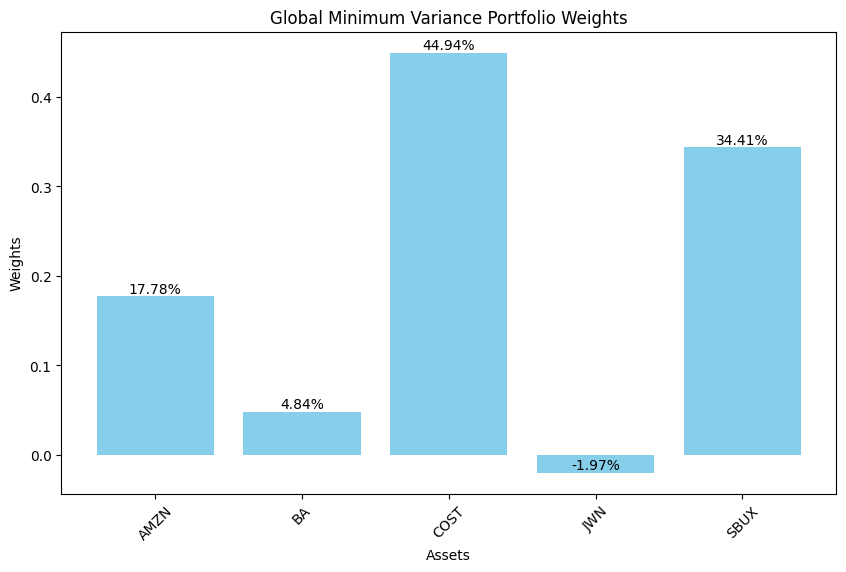

In [ ]:
# Plotting the weights
plt.figure(figsize=(10, 6))
plt.bar(cov.columns, optimal_weights_GMVP, color='skyblue')
plt.title('Global Minimum Variance Portfolio Weights')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.xticks(rotation=45)

# Add labels to the bars
for i, weight in enumerate(optimal_weights_GMVP):
    plt.text(i, weight, f'{weight:.2%}', ha='center', va='bottom')

plt.show()

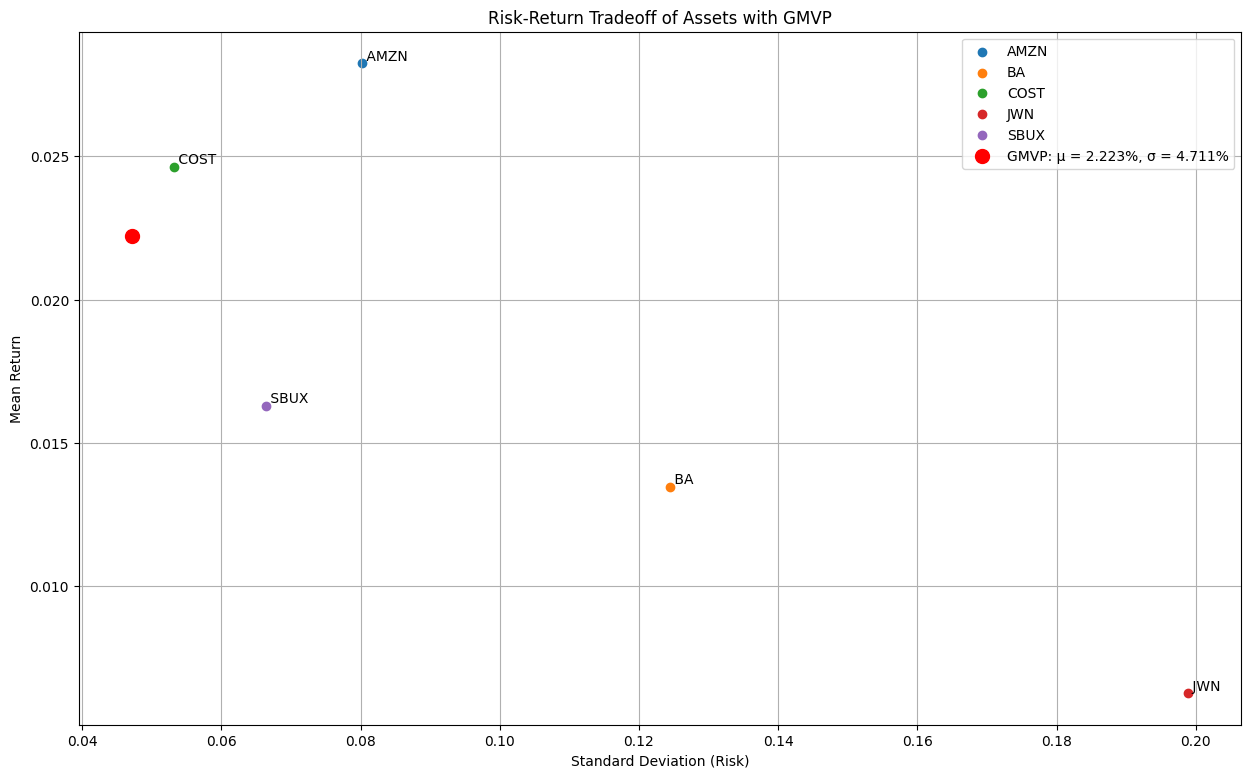

In [ ]:
# Compute the expected return and standard deviation for the global minimum variance portfolio
expected_return_gmvp = np.dot(optimal_weights_GMVP, mu)
standard_deviation_gmvp = np.sqrt(np.dot(optimal_weights_GMVP.T, np.dot(cov, optimal_weights_GMVP)))

# Adding the point to the risk-return graph
plt.figure(figsize=(15, 9))
for stock in mu.index:
    plt.scatter(sig[stock], mu[stock], label=stock)
    plt.text(sig[stock], mu[stock], f" {stock}", verticalalignment='bottom')


# Add the GMVP point
plt.scatter(standard_deviation_gmvp, expected_return_gmvp, color='red', label=f'GMVP: µ = {round(expected_return_gmvp*100,3)}%, σ = {round(standard_deviation_gmvp*100,3)}%', s=100)

plt.title('Risk-Return Tradeoff of Assets with GMVP')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Mean Return')
plt.legend()
plt.grid()
plt.show()

These weights indicate a heavy allocation towards AAPL (66.61%), suggesting that AAPL is perceived to offer the best risk-return tradeoff among the assets considered, according to the optimization. GOOGL and SBUX also receive significant positive weights, indicating a favorable view on their contributions to portfolio diversification and return. Interestingly, the portfolio includes a short position in MSFT (-3.86%), which implies that the optimization process sees an opportunity to reduce portfolio variance by financing a portion of the investments in other assets through shorting MSFT.

4. Of the five stocks, determine the stock with the largest estimated expected return. Use this maximum average return as the target return for the computation of an efficient portfolio allowing for short-sales. That is, find the minimum variance portfolio that has an expected return equal to this target return. The minimization problem is

\begin{align*}
\min_{\mathbf{x}}\sigma_{p,x}^{2}  &  =\mathbf{x}^{\prime}\Sigma \mathbf{x}\text{ s.t.}\\
\mu_{p,x}  &  =\mathbf{x}^{\prime}\mathbf{\mu}=\mu_{p}^{0}=\text{ target return}\\
\mathbf{x}^{\prime}\mathbf{1}  &  =1
\end{align*}

where $\mathbf{x}$ is the vector of portfolio weights, $\mu$ is the vector of expected returns and $\mu_{p}^{0}$ is the target expected return.  Are there any negative weights in this portfolio? Compute the expected return, variance and standard deviation of this portfolio. Finally, compute the covariance between the global minimum variance portfolio and the above efficient portfolio using the formula $\mathrm{cov}(R_{p,m}, R_{p,x})=\mathbf{m}^{\prime}\Sigma\mathbf{x}$.



In [ ]:
# Determine the stock with the largest estimated expected return
max_expected_return = mu.max()
target_return = max_expected_return
target_returns = np.linspace(mu.min(), mu.max()*1.2, 100)


# Additional constraint: Portfolio's expected return = target return
return_constraint = ({'type': 'eq', 'fun': lambda weights: np.dot(weights, mu) - target_return})

constraints_with_return = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                           {'type': 'eq', 'fun': lambda weights: np.dot(weights, mu) - target_return}]

# Re-run the optimization for the efficient portfolio
efficient_portfolio = minimize(portfolio_variance, initial_guess, args=(cov,), method='SLSQP', bounds=bounds, constraints=constraints_with_return)

efficient_weights = efficient_portfolio.x

# Re-compute the expected return and standard deviation for the efficient portfolio
expected_return_efficient = np.dot(efficient_weights, mu)
standard_deviation_efficient = np.sqrt(np.dot(efficient_weights.T, np.dot(cov, efficient_weights)))


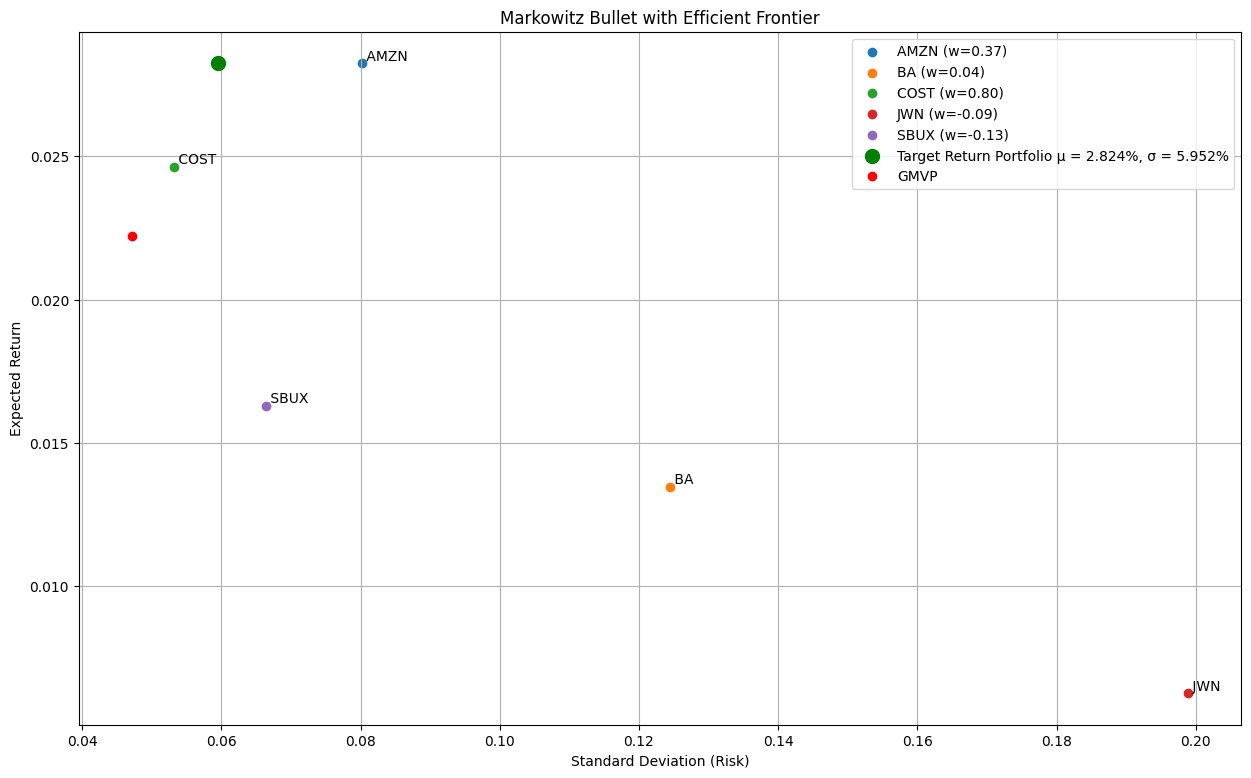

In [ ]:

# Re-plotting the Markowitz bullet with corrections
plt.figure(figsize=(15, 9))
for stock in mu.index:
    plt.scatter(sig[mu.index.get_loc(stock)], mu[stock], label=f"{stock} (w={efficient_weights[mu.index.get_loc(stock)]:.2f})")
    plt.text(sig[stock], mu[stock], f" {stock}", verticalalignment='bottom')

plt.scatter(standard_deviation_efficient, expected_return_efficient, color='green', s=100, label=f'Target Return Portfolio µ = {round(expected_return_efficient*100,3)}%, σ = {round(standard_deviation_efficient*100,3)}%', zorder=5)
plt.plot(standard_deviation_gmvp, expected_return_gmvp, 'ro', label='GMVP')  # Re-plot GMVP for comparison
plt.title('Markowitz Bullet with Efficient Frontier')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend()

plt.grid()
plt.show()

In [ ]:
covariance_gmvp_efficient = optimal_weights_GMVP.T @ cov.values @ efficient_weights
print(f'Covariance between GMVP and Efficient Portfolio: {covariance_gmvp_efficient}')

Covariance between GMVP and Efficient Portfolio: 0.0021222174176120114


5. Using the fact that all efficient portfolios (that allow short sales) can be written as a convex combination of two efficient portfolios (that allow short sales), compute efficient portfolios as convex combinations of the global minimum variance portfolio and the efficient portfolio computed in question 4. That is, compute

$$
\mathbf{z} = \alpha \times \mathbf{m} + (1-\alpha) \times \mathbf{x}
$$

for values of $\alpha$ between $1$ and $-1$ (e.g., make a grid for $\alpha = 1, 0.9, \cdots, -1$). Compute the expected return, variance and standard deviation of these portfolios.



In [ ]:
# Grid for alpha values
alphas = np.linspace(1, -1, 21)

# Efficient Portfolio weights from question 4
efficient_weights = efficient_portfolio.x

# Initialize lists to store results
expected_returns = []
variances = []
standard_deviations = []

# Compute portfolio characteristics for each alpha
for alpha in alphas:
    z_weights = alpha * optimal_weights_GMVP + (1 - alpha) * efficient_weights
    expected_return_z = np.dot(z_weights, mu)
    variance_z = np.dot(z_weights.T, np.dot(cov, z_weights))
    std_deviation_z = np.sqrt(variance_z)

    expected_returns.append(expected_return_z)
    variances.append(variance_z)
    standard_deviations.append(std_deviation_z)

results_df = pd.DataFrame({
    'Alpha': alphas,
    'Expected Return': expected_returns,
    'Variance': variances,
    'Standard Deviation': standard_deviations
})


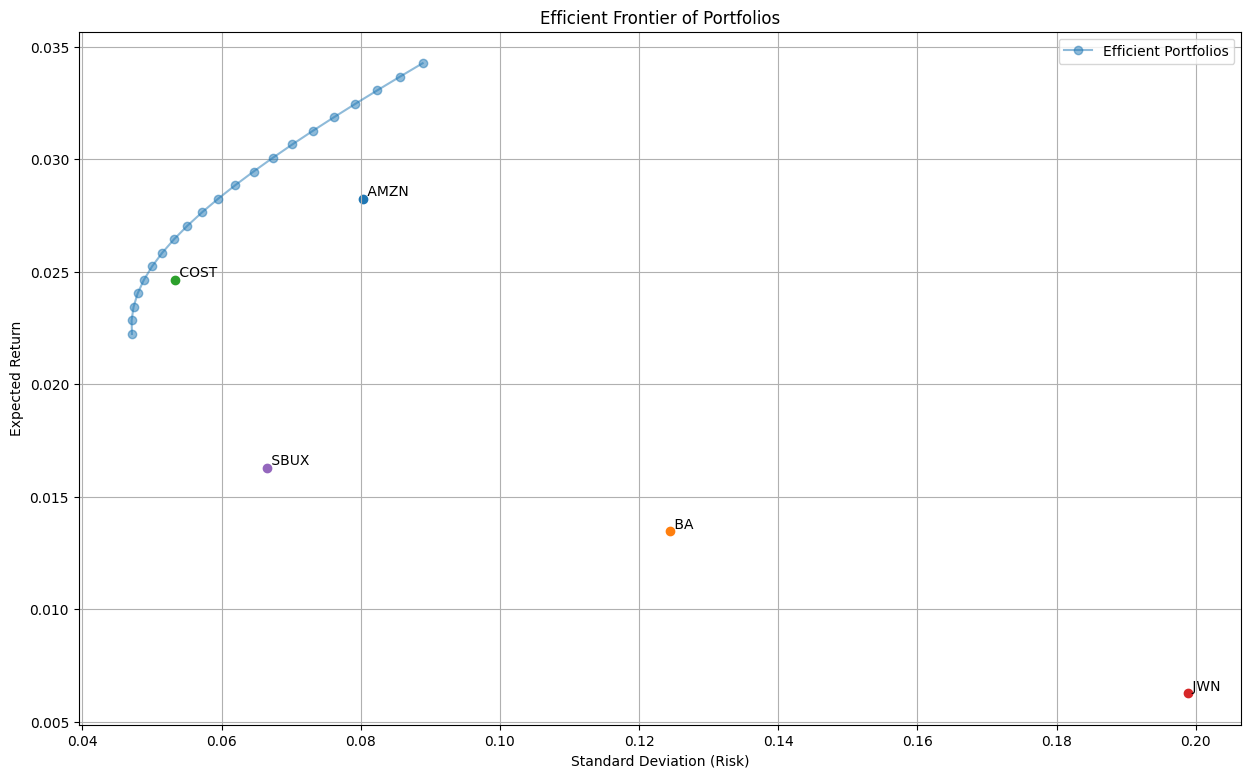

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(standard_deviations, expected_returns, marker='o', linestyle='-', label='Efficient Portfolios', alpha=0.5)
for stock in mu.index:
    plt.scatter(sig[mu.index.get_loc(stock)], mu[stock])
    plt.text(sig[stock], mu[stock], f" {stock}", verticalalignment='bottom')

plt.title('Efficient Frontier of Portfolios')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

# Displaying recalculated metrics for portfolios across different alphas
portfolio_metrics = pd.DataFrame({
    'Alpha': alphas,
    'Expected Return': expected_returns,
    'Variance': variances,
    'Standard Deviation': standard_deviations
})


6. Plot the Markowitz bullet based on the efficient portfolios you computed in question 5. On the plot, indicate the location of the minimum variance portfolio and the location of the efficient portfolio found in question 4.



In [ ]:
# Lists to store computed values
expected_returns_z = []
variances_z = []
standard_deviations_z = []

# Compute portfolio characteristics for each alpha
for alpha in alphas:
    z_weights = alpha * optimal_weights_GMVP + (1 - alpha) * efficient_weights
    exp_return_z = np.dot(z_weights, mu)
    variance_z = np.dot(z_weights.T, np.dot(cov, z_weights))
    std_deviation_z = np.sqrt(variance_z)

    expected_returns_z.append(exp_return_z)
    variances_z.append(variance_z)
    standard_deviations_z.append(std_deviation_z)

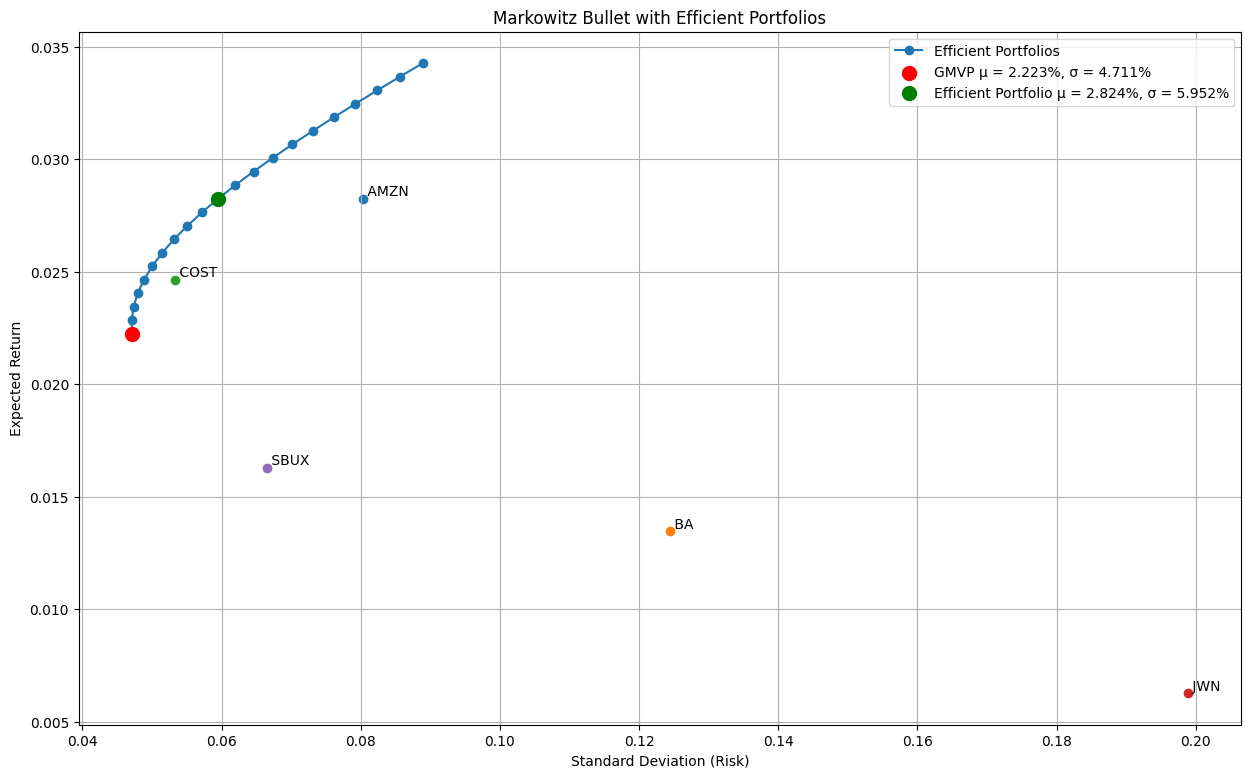

In [ ]:
# Plotting the efficient frontier with computed portfolios
plt.figure(figsize=(15, 9))
plt.plot(standard_deviations_z, expected_returns_z, 'o-', label='Efficient Portfolios')

# Marking the GMVP and efficient portfolio on the plot
gmvp_std = np.sqrt(optimal_weights_GMVP.T @ cov @ optimal_weights_GMVP)
gmvp_return = np.dot(optimal_weights_GMVP, mu)
efficient_std = np.sqrt(efficient_weights.T @ cov @ efficient_weights)
efficient_return = np.dot(efficient_weights, mu)

plt.scatter(gmvp_std, gmvp_return, color='red', s=100, label=f'GMVP µ = {round(gmvp_return*100,3)}%, σ = {round(gmvp_std*100,3)}%', zorder=5)
plt.scatter(efficient_std, efficient_return, color='green', s=100,label=f'Efficient Portfolio µ = {round(efficient_return*100,3)}%, σ = {round(efficient_std*100,3)}%', zorder=5)


for stock in mu.index:
    plt.scatter(sig[mu.index.get_loc(stock)], mu[stock])
    plt.text(sig[stock], mu[stock], f" {stock}", verticalalignment='bottom')


plt.title('Markowitz Bullet with Efficient Portfolios')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

7. Compute the tangency portfolio assuming the risk-free rate is $0.005$ ($r_f = 0.5\%$) per month. That is, solve

\begin{align*}
\max_{\mathbf{t}} =\frac{\mathbf{t}^{\prime}\mathbf{\mu}-r_{f}}{\left(\mathbf{t}^{\prime}\Sigma \mathbf{t}\right)^{1/2}}
\end{align*}

subject to

\begin{align*}
\mathbf{t}^{\prime}\mathbf{1}=1
\end{align*}

where $\mathbf{t}$ denotes the portfolio weights in the tangency portfolio. Are there any negative weights in the tangency portfolio? If so, interpret them.



In [ ]:
rf = 0.005

In [ ]:
# Objective function: Maximize the Sharpe ratio
def negative_sharpe_ratio(weights, mu, cov, rf):
    portfolio_return = np.dot(weights, mu)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility
    return -sharpe_ratio  # Minimize negative Sharpe ratio

# Constraint: Sum of weights = 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Initial guess (equal weighting)
initial_guess = np.ones(len(mu)) / len(mu)

# Boundaries: Allow short sales, so no bounds on weights
bounds = [(None, None) for _ in range(len(mu))]

# Minimize the negative Sharpe ratio
optimal_tangency_portfolio = minimize(negative_sharpe_ratio, initial_guess, args=(mu, cov, rf), method='SLSQP', bounds=bounds, constraints=constraints)

tangency_weights = optimal_tangency_portfolio.x

# Compute the expected return, variance, and standard deviation for the tangency portfolio
expected_return_tangency = np.dot(tangency_weights, mu)
variance_tangency = np.dot(tangency_weights.T, np.dot(cov, tangency_weights))
standard_deviation_tangency = np.sqrt(variance_tangency)

# Display results
tangency_portfolio_details = {
    'Expected Return': expected_return_tangency,
    'Variance': variance_tangency,
    'Standard Deviation': standard_deviation_tangency,
    'Weights': tangency_weights
}

In [ ]:
for stock in mu.index:
    if tangency_weights[mu.index.get_loc(stock)] < 0:
        print(f'{stock} has a NEGATIVE weight in the tangency portfolio of {round(100*tangency_weights[mu.index.get_loc(stock)],3)}% \n')
    else:
        print(f'{stock} has a positive weight in the tangency portfolio of {round(100*tangency_weights[mu.index.get_loc(stock)],3)}% \n')

AMZN has a positive weight in the tangency portfolio of 25.101% 

BA has a positive weight in the tangency portfolio of 5.037% 

COST has a positive weight in the tangency portfolio of 68.943% 

JWN has a NEGATIVE weight in the tangency portfolio of -6.119% 

SBUX has a positive weight in the tangency portfolio of 7.037% 



Negative weights in the tangency portfolio indicate short positions in those assets. This means that the optimization suggests borrowing these assets to sell them now with the expectation of buying them back at a lower price in the future. The proceeds from the short sales are then used to finance larger positions in the assets with positive weights.



8. On the graph with the Markowitz bullet, plot the efficient portfolios that are combinations of T-bills and the tangency portfolio. Indicate the location of the tangency portfolio on the graph.



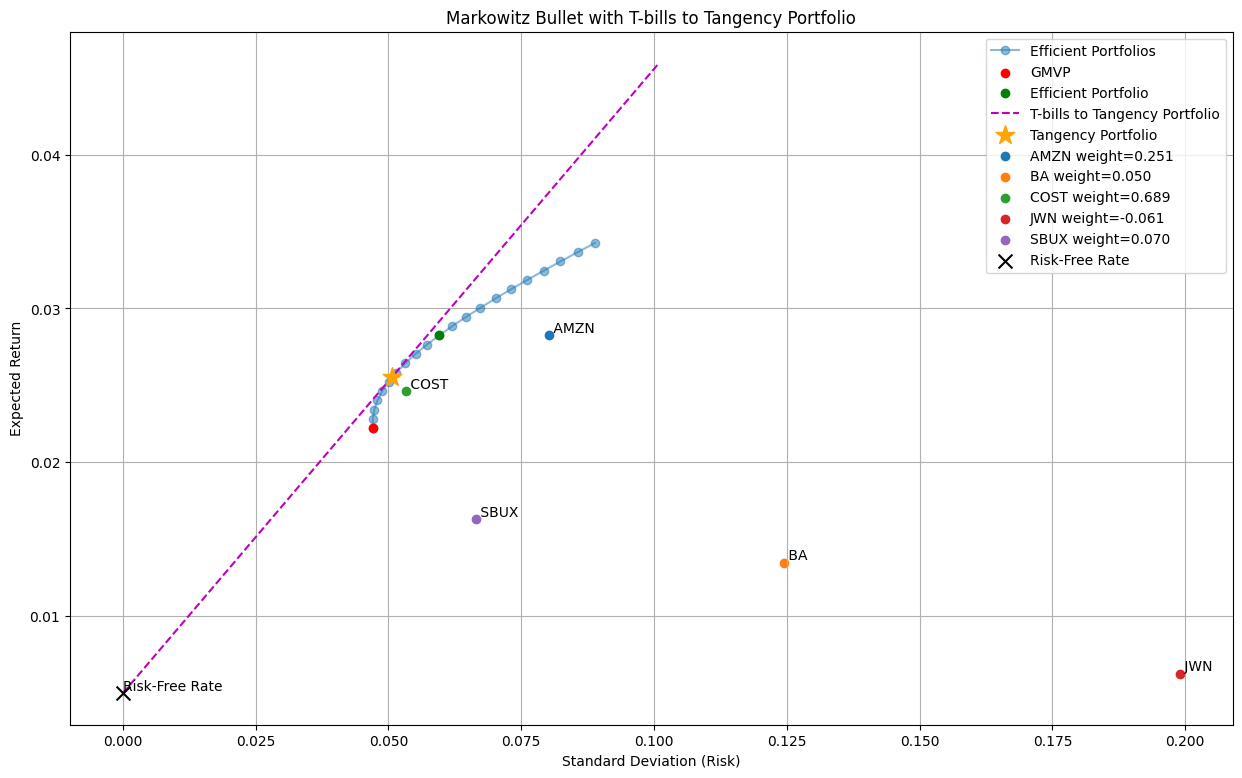

In [ ]:
# Efficient frontier for combinations of T-bills and the tangency portfolio
risk_free_rate = rf
tangency_return = expected_return_tangency
tangency_std = standard_deviation_tangency

# Compute the efficient frontier for combinations of T-bills and the tangency portfolio
portfolio_returns = np.linspace(risk_free_rate, tangency_return*1.8, 100)
portfolio_stds = (portfolio_returns - risk_free_rate) / ((tangency_return - risk_free_rate) / tangency_std)

# Re-plotting the Markowitz bullet with the addition of the T-bills and tangency portfolio efficient frontier
plt.figure(figsize=(15, 9))
plt.plot(standard_deviations_z, expected_returns_z, 'o-', label='Efficient Portfolios', alpha=0.5)
plt.scatter(gmvp_std, gmvp_return, color='red', label='GMVP', zorder=5)
plt.scatter(efficient_std, efficient_return, color='green', label='Efficient Portfolio', zorder=5)

# Adding the line for the efficient frontier between T-bills and the tangency portfolio
plt.plot(portfolio_stds, portfolio_returns, 'm--', label='T-bills to Tangency Portfolio')

# Marking the tangency portfolio on the plot
plt.scatter(tangency_std, tangency_return, color='orange', marker='*', s=200, label='Tangency Portfolio', zorder=5)

for stock in mu.index:
    plt.scatter(sig[mu.index.get_loc(stock)], mu[stock], label=f"{stock} weight={tangency_weights[mu.index.get_loc(stock)]:.3f}")
    plt.text(sig[stock], mu[stock], f" {stock}", verticalalignment='bottom')

plt.scatter(0, risk_free_rate, color='black', marker='x', s=100, label=f'Risk-Free Rate', zorder=5)
plt.text(0, risk_free_rate, f"Risk-Free Rate", verticalalignment='bottom')

#plt.ylim(0, max(portfolio_returns)+rf)


plt.title('Markowitz Bullet with T-bills to Tangency Portfolio')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

9. Find the efficient portfolio of combinations of T-bills and the tangency portfolio that has the same SD value as Starbucks. What is the expected return on this portfolio? Indicate the location of this portfolio on your graph of the Markowitz bullet.



In [ ]:
# Target standard deviation is that of Starbucks (SBUX)
target_sd = sig['SBUX']

# Calculate the expected return of the efficient portfolio that combines T-bills and the tangency portfolio with the same SD as SBUX
target_return_efficient_combo = risk_free_rate + ((tangency_return - risk_free_rate) / tangency_std) * target_sd

# Weight of the tangency portfolio in the SBUX equivalent portfolio
weight_tangency_sbux = (target_return_efficient_combo - risk_free_rate) / (tangency_return - risk_free_rate)

# Weight of the risk-free asset (T-bills) in the SBUX equivalent portfolio
weight_rf_sbux = 1 - weight_tangency_sbux



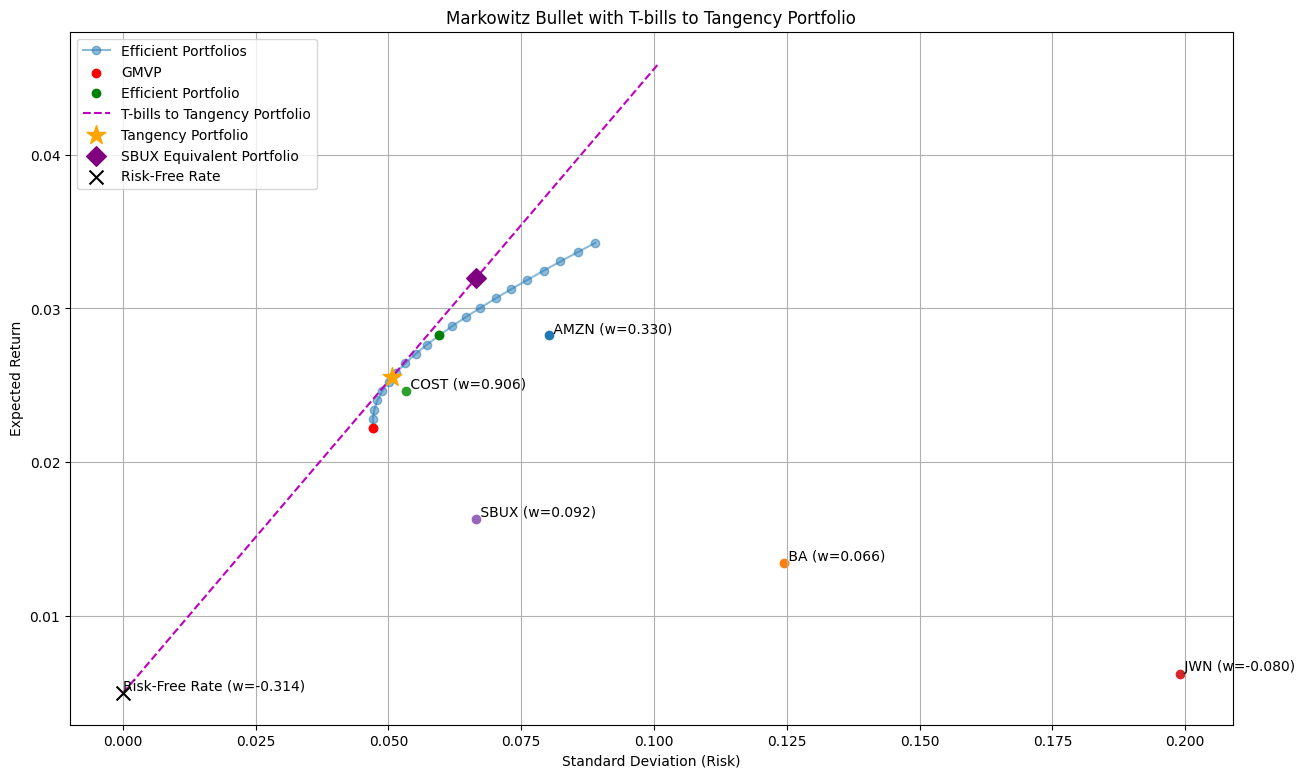

In [ ]:

# Re-plotting everything to indicate the location of the specified portfolio
plt.figure(figsize=(15, 9))
plt.plot(standard_deviations_z, expected_returns_z, 'o-', label='Efficient Portfolios', alpha=0.5)
plt.scatter(gmvp_std, gmvp_return, color='red', label='GMVP', zorder=5)
plt.scatter(efficient_std, efficient_return, color='green', label='Efficient Portfolio', zorder=5)
plt.plot(portfolio_stds, portfolio_returns, 'm--', label='T-bills to Tangency Portfolio')
plt.scatter(tangency_std, tangency_return, color='orange', marker='*', s=200, label='Tangency Portfolio', zorder=5)

# Marking the Starbucks equivalent portfolio
plt.scatter(target_sd, target_return_efficient_combo, color='purple', marker='D', s=100, label='SBUX Equivalent Portfolio', zorder=5)

for stock in mu.index:
    plt.scatter(sig[stock], mu[stock])
    plt.text(sig[stock], mu[stock], f" {stock} (w={weight_tangency_sbux * tangency_weights[mu.index.get_loc(stock)]:.3f})", verticalalignment='bottom')

plt.scatter(0, risk_free_rate, color='black', marker='x', s=100, label=f'Risk-Free Rate', zorder=5)
plt.text(0, risk_free_rate, f"Risk-Free Rate (w={weight_rf_sbux:.3f})", verticalalignment='bottom')

#plt.ylim(0, max(portfolio_returns)+rf)
plt.title('Markowitz Bullet with T-bills to Tangency Portfolio')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


10. Review Lecture Notes 11 and the corresponding codes.  Create risk reports that include rho and beta for the global minimum variance portfolio in Question 3, the maximum expected return portoflio in Question 4, and the tangency portfolio in Question 7. Comment on what you find.   You may assume any starting wealth for investment.

In [ ]:
def build_report(weights, cov=cov, mu=mu):
    std = np.sqrt(np.dot(weights, np.dot(cov, weights)))

    RM = np.dot(weights, np.dot(cov, weights))

    MCR = np.dot(cov, weights) / std
    CR = weights * MCR
    PCR = CR / std

    # Beta calculation for the tangency portfolio
    optimal_weights_GMVP.T @ cov.values @ efficient_weights
    beta = PCR / weights

    # Rho calculation for the tangency portfolio
    rho = MCR / np.sqrt(np.diag(cov))

    # Creating the risk report for the tangency portfolio with correct stock names as index
    risk_report = pd.DataFrame({
        'Weight': weights,
        'MCR': MCR,
        'CR': CR,
        'PCR': PCR,
        'Beta': beta,
        'Rho': rho
    }, index=mu.index)

    return risk_report

In [ ]:
risk_report_tangency = build_report(tangency_weights)

print('Tangency Portfolio')
risk_report_tangency


Tangency Portfolio


,Weight,MCR,CR,PCR,Beta,Rho
AMZN,0.251015,0.057291,0.014381,0.284305,1.132622,0.713638
BA,0.050373,0.020878,0.001052,0.020791,0.412751,0.167758
COST,0.689429,0.048412,0.033377,0.659839,0.957080,0.908819
JWN,-0.061186,0.003127,-0.000191,-0.003782,0.061811,0.015715
SBUX,0.070369,0.027924,0.001965,0.038846,0.552038,0.420155


In [ ]:
risk_report_max = build_report(efficient_weights)

print('Maximum Return Portfolio')
risk_report_max

Maximum Return Portfolio


,Weight,MCR,CR,PCR,Beta,Rho
AMZN,0.373314,0.060440,0.022563,0.379076,1.015435,0.752856
BA,0.042065,0.005479,0.000230,0.003872,0.092046,0.044022
COST,0.803427,0.044784,0.035981,0.604503,0.752405,0.840713
JWN,-0.089938,-0.025069,0.002255,0.037880,-0.421173,-0.126005
SBUX,-0.128868,0.011699,-0.001508,-0.025330,0.196559,0.176036


In [ ]:
risk_report_gmvp = build_report(optimal_weights_GMVP)

print('GMV Portfolio')
risk_report_gmvp

GMV Portfolio


,Weight,MCR,CR,PCR,Beta,Rho
AMZN,0.177780,0.050595,0.008995,0.190940,1.074024,0.630228
BA,0.048448,0.041049,0.001989,0.042217,0.871374,0.329830
COST,0.449394,0.044035,0.019789,0.420076,0.934760,0.826647
JWN,-0.019689,0.049578,-0.000976,-0.020722,1.052441,0.249199
SBUX,0.344066,0.050315,0.017312,0.367489,1.068076,0.757066
